In [2]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import explode, split, col, array_contains, udf, expr
import matplotlib.pyplot as plt
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
import re
from pyspark.ml.regression import LinearRegression
from pyspark.sql import functions as F
import matplotlib.pyplot as plt


In [3]:
spark = SparkSession.builder.appName("youtube_data_processing").getOrCreate()

In [4]:
youtube = spark.read.option("quote", "\"").option("escape", "\"").option("multiLine", True).option("ignoreLeadingWhiteSpace", True).csv('gs://msca-bdp-student-gcs/Group2_Final_Project/Copy_of_youtube_comments.csv', header=True, inferSchema=True)

In [5]:
youtube = youtube.dropna()
youtube = youtube.withColumn("Likes", col("Likes").cast(IntegerType()))
youtube = youtube.withColumn("tag", expr("substr(tag, 10, length(tag) - 13)"))

In [6]:
youtube.show()

+--------------------+--------------------+-----+----------------+--------------------+-----+--------------------+------------------+--------------------+-------------------+--------------------+-----+
|         Video Title|           Video URL|Views|Publication Date|         Description|Likes|         Channel URL|      Channel Name|       Channel Image|Channel Subscribers|            Comments|  tag|
+--------------------+--------------------+-----+----------------+--------------------+-----+--------------------+------------------+--------------------+-------------------+--------------------+-----+
|SELLING Comic Boo...|https://www.youtu...|  574|     4 hours ago|Please like this ...|   74|https://www.youtu...|StickyGoose Comics|https://yt3.ggpht...|              7.93K|It’s cuts both wa...|Books|
|SELLING Comic Boo...|https://www.youtu...|  574|     4 hours ago|Please like this ...|   74|https://www.youtu...|StickyGoose Comics|https://yt3.ggpht...|              7.93K|As a small time e.

In [7]:
youtube.describe().show()


+-------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+-------------------+-------------------+---------------+
|summary|         Video Title|           Video URL|             Views|    Publication Date|         Description|             Likes|         Channel URL|        Channel Name|       Channel Image|Channel Subscribers|           Comments|            tag|
+-------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+-------------------+-------------------+---------------+
|  count|             1252650|             1252650|           1252650|             1252650|             1252650|             10685|             1252650|             1252650|             1252650|            1252650|            1252650|        12526

In [8]:
aggregated_youtube = youtube.groupBy("Video URL").agg(
    F.first("Likes").alias("Likes"),
    F.first("Video Title").alias("Video Title"),
    F.first("Channel Name").alias("Channel Name"),
    F.first("tag").alias("tag"),
    F.count("Comments").alias("Total Comments")
)


aggregated_youtube.show()

+--------------------+-----+------------------------+--------------------+----------------+--------------+
|           Video URL|Likes|             Video Title|        Channel Name|             tag|Total Comments|
+--------------------+-----+------------------------+--------------------+----------------+--------------+
|https://www.youtu...| null|    I read 20 popular...|        Sophie Jayne|           Books|           118|
|https://www.youtu...| null|    Real Horror Story...| V R Facts In Telugu|     interesting|          4112|
|https://www.youtu...| null|    Must-know Beginne...|Josh's Gaming Garden|       life tips|            88|
|https://www.youtu...|   36|    NZ How Much Does ...|       Opes Partners|Financial Advice|             2|
|https://www.youtu...| null|    How Money Is Made...|      Wondastic Tech|     interesting|           713|
|https://www.youtu...| null|    Do THIS Instead o...|        Jungle Scout|           Books|           505|
|https://www.youtu...| null|    Love 

In [19]:
tag_comments = aggregated_youtube.groupBy("tag").agg(
    F.sum("Total Comments").alias("sum of comments")
)
tag_comments.show()

+----------------+---------------+
|             tag|sum of comments|
+----------------+---------------+
| problem-solving|          35034|
|    Relationship|         230696|
|     Programming|          74559|
|Financial Advice|          72316|
|           Books|         128267|
|     interesting|         526405|
|       life tips|         185373|
+----------------+---------------+



In [20]:
tag_comments_data = tag_comments.collect()

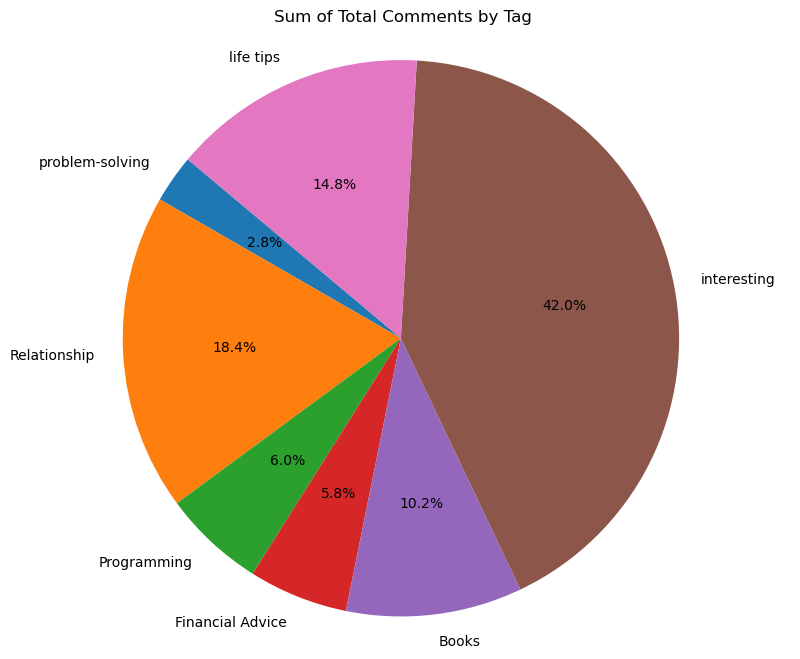

In [21]:

# Extracting tags and their corresponding sum of comments
tags = [row['tag'] for row in tag_comments_data]
sum_of_comments = [row['sum of comments'] for row in tag_comments_data]

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(sum_of_comments, labels=tags, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Sum of Total Comments by Tag')
plt.show()

In [ ]:
youtube_df = youtube.toPandas()

# Plotting
plt.figure(figsize=(10, 8))
for tag, group in youtube_df.groupby('tag'):
    plt.scatter(group['Comments'], group['Views'], label=tag)

plt.xlabel('Comments')
plt.ylabel('Views')
plt.title('YouTube Comments vs Views Colored by Tag')
plt.legend()
plt.show()

In [9]:
aggregated_youtube.write.csv('gs://msca-bdp-student-gcs/Group2_Final_Project/visual/aggregated_youtube.csv', header=True)